### Imports 👽

In [37]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

sys.path.append(os.path.abspath(os.path.join('../..', 'src')))
from data_classes.enums import Scenario, SamplingMethod
from data_classes.scenario import ScenarioSettings

### Prepare Data to Compare ⚙️

In [ ]:
scenario = Scenario.PROJECTILE

output_dir = os.path.abspath(os.path.join('../..', 'data', scenario.value, 'output'))

sampling_types = [SamplingMethod.SOBOL]
epochs_types = [100, 500, 1000, 1500, 2000]

dfs = []
for sampling_type in sampling_types:
    for epochs in epochs_types:
        df = pd.read_csv(os.path.join(output_dir, f'{sampling_type.value}_{epochs}epochs_results.csv'))
        df['epochs'] = epochs
        df['sampling_type'] = sampling_type.value
        dfs.append(df)

together_df = pd.concat(dfs, ignore_index=True)
together_df.to_csv(os.path.join(output_dir, 'together.csv'), index=False)

# Filter
depths = [4,8,16] # [4,8,16]
epochs = [1000,1500,2000] # [100,500,1000,1500,2000]
widths = [6,12,24] # [6,12,24]
learning_rates = [0.01,0.001] # [0.01,0.001]
lambdas = [1.0e-04,1.0e-05,1.0e-06,1e-07] # [1.0e-04,1.0e-05,1.0e-06,1e-07]
# training_set_sizes = [128, 256, 512, 1024, 2048, 4096, 8192] # Sum Sines [128, 256, 512, 1024, 2048, 4096, 8192]
training_set_sizes = [16, 32, 64, 128, 256, 512, 1024] # Projectile [16, 32, 64, 128, 256, 512, 1024]
# print(ScenarioSettings(scenario).TRAINING_SET_SIZES)

together_df = together_df[
    together_df['epochs'].isin(epochs) &
    together_df['num_hidden_layers'].isin(widths) &
    together_df['depth'].isin(depths) &
    together_df['learning_rate'].isin(learning_rates)
]

### Analysis 📊

#### Distribution of reg_params among the best NNs

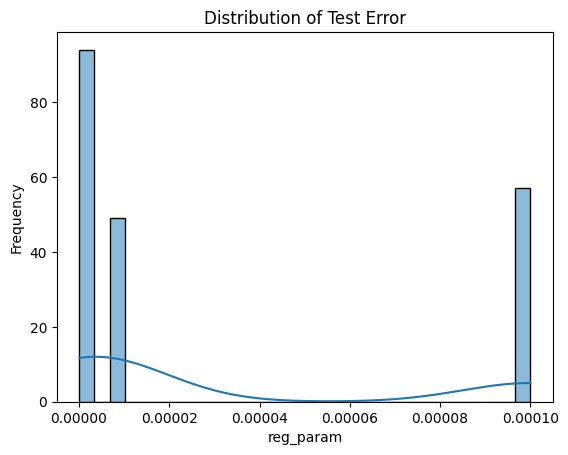

In [39]:
# test_error_limit = .02
# good_nns_df = together_df[together_df['test_error'] <= test_error_limit]
# bad_nns_df = together_df[together_df['test_error'] > test_error_limit]

good_nns_df = together_df.nsmallest(200, 'test_error')
bad_nns_df = together_df.drop(good_nns_df.index)

sns.histplot(good_nns_df['reg_param'], kde=True, bins=30)
plt.title('Distribution of Test Error')
plt.xlabel('reg_param')
plt.ylabel('Frequency')
plt.show()

In [40]:
print('Number of Good NNs: ', len(good_nns_df))
print('Number of Bad NNs : ', len(bad_nns_df))

Number of Good NNs:  200
Number of Bad NNs :  1312


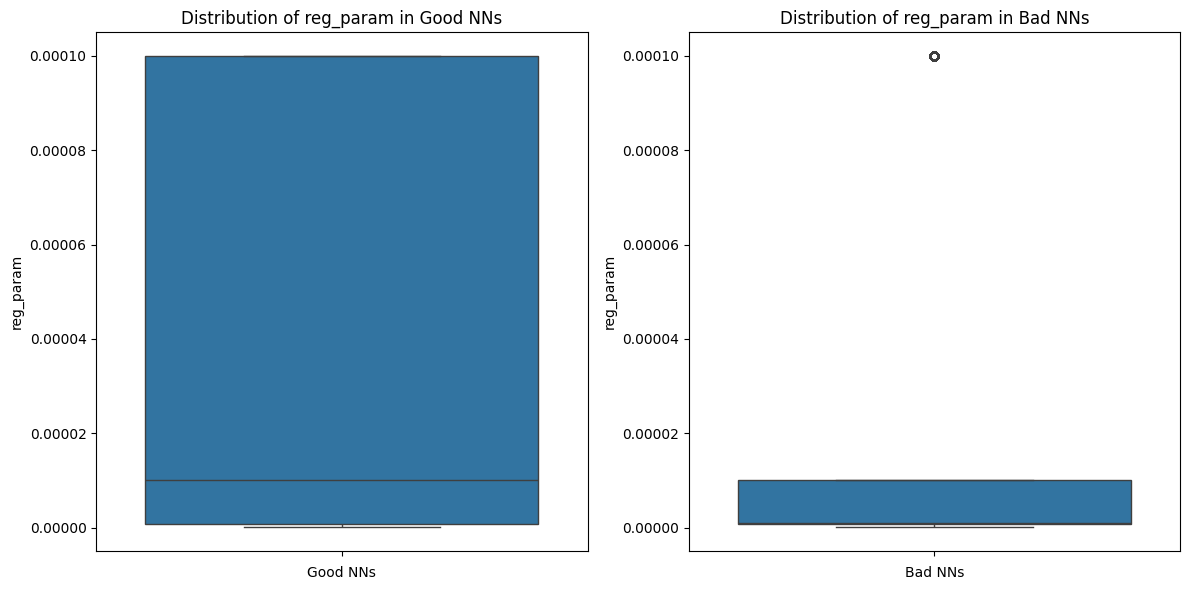

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=good_nns_df, y="reg_param", ax=axes[0])
axes[0].set_title("Distribution of reg_param in Good NNs")
axes[0].set_ylabel("reg_param")
axes[0].set_xlabel("Good NNs")

sns.boxplot(data=bad_nns_df, y="reg_param", ax=axes[1])
axes[1].set_title("Distribution of reg_param in Bad NNs")
axes[1].set_ylabel("reg_param")
axes[1].set_xlabel("Bad NNs")

plt.tight_layout()
plt.show()

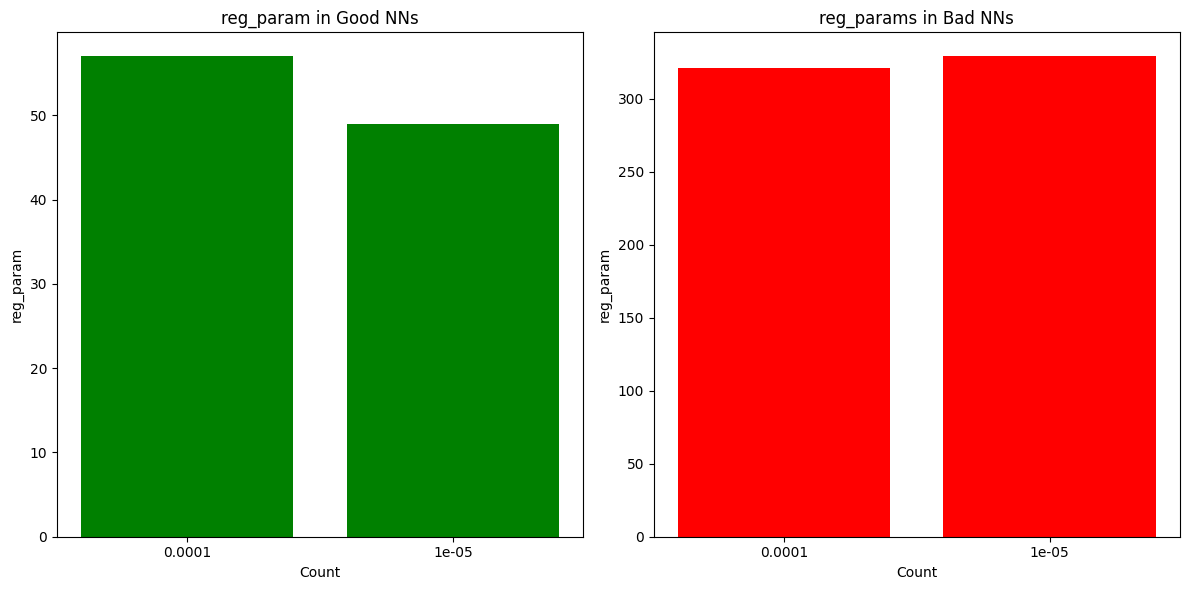

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Count occurrences of each reg_param in good_nns
good_reg_params_counts = good_nns_df['reg_param'].value_counts().reindex(lambdas, fill_value=0)
axes[0].bar(good_reg_params_counts.index.astype(str), good_reg_params_counts.values, color='green')
axes[0].set_title("reg_param in Good NNs")
axes[0].set_ylabel("reg_param")
axes[0].set_xlabel("Count")

# Count occurrences of each reg_param in bad_nns
bad_reg_param_counts = bad_nns_df['reg_param'].value_counts().reindex(lambdas, fill_value=0)
axes[1].bar(bad_reg_param_counts.index.astype(str), bad_reg_param_counts.values, color='red')
axes[1].set_title("reg_params in Bad NNs")
axes[1].set_ylabel("reg_param")
axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()


#### Difference between best candidates for reg_param

Best Test Error for reg_param 0.0001: 0.0418340973556041
Best Test Error for reg_param 1e-05: 0.0386489927768707


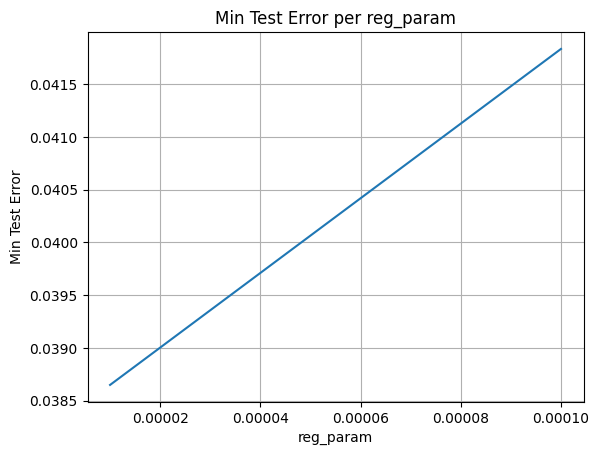

In [43]:
test_errors = []
for i in lambdas:
    test_errors.append(together_df.loc[together_df['reg_param']==i, 'test_error'].min())
    print(f'Best Test Error for reg_param {i}: {test_errors[-1]}')

plt.plot(lambdas, test_errors)
plt.xlabel('reg_param')
plt.ylabel('Min Test Error')
plt.title('Min Test Error per reg_param')
plt.grid(True)
plt.show()

Mean Test Error for 0.0001 neurons per layer (reg_param): 3.998151465560551
Mean Test Error for 1e-05 neurons per layer (reg_param): 4.054250716936415


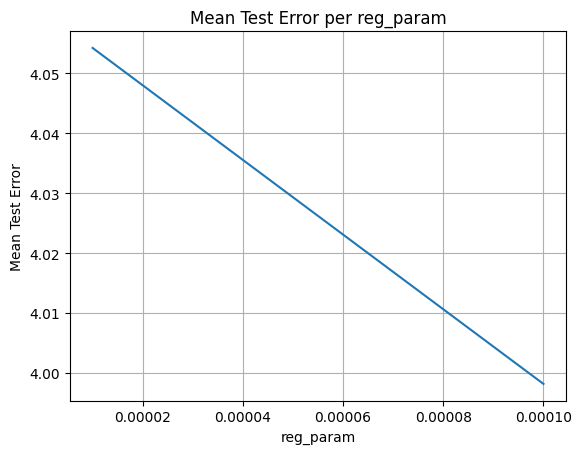

In [44]:
test_errors = []
for i in lambdas:
    test_errors.append(together_df.loc[together_df['reg_param']==i, 'test_error'].mean())
    print(f'Mean Test Error for {i} neurons per layer (reg_param): {test_errors[-1]}')

plt.plot(lambdas, test_errors)
plt.xlabel('reg_param')
plt.ylabel('Mean Test Error')
plt.title('Mean Test Error per reg_param')
plt.grid(True)
plt.show()

Mean among 10 best test errors for 0.0001 neurons per layer (reg_param): 0.05535413250327105
Mean among 10 best test errors for 1e-05 neurons per layer (reg_param): 0.05193458981811995


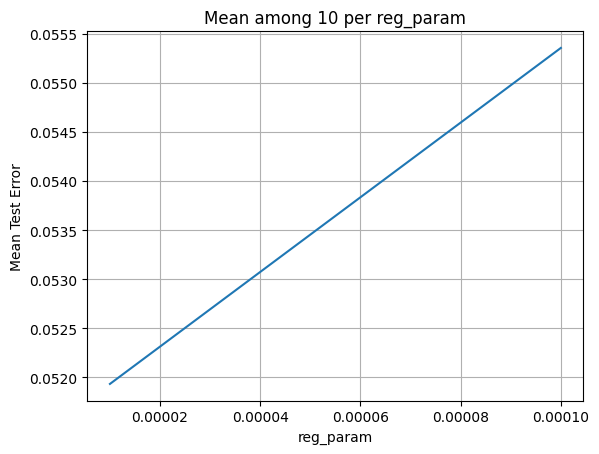

In [45]:
test_errors = []
num_best = 10
for i in lambdas:
    selection_df = together_df.loc[together_df['reg_param']==i].nsmallest(num_best, 'test_error')
    test_errors.append(selection_df.test_error.mean())
    print(f'Mean among {num_best} best test errors for {i} neurons per layer (reg_param): {test_errors[-1]}')

plt.plot(lambdas, test_errors)
plt.xlabel('reg_param')
plt.ylabel('Mean Test Error')
plt.title(f'Mean among {num_best} per reg_param')
plt.grid(True)
plt.show()